In [ ]:
# Setup

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import sql
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pyspark

spark = (
    pyspark.sql.SparkSession.builder.appName("Visualization")
    .master("yarn")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.instances", "2")
    .getOrCreate()
)
spark


# JSON Classes

In [ ]:
class Category:
  def __init__(self, cat_pattern):
    self.depth1, self.depth2, self.depth3, self.depth4 = list(map(int, cat_pattern.split("/")))[:4]
  
  def __str__(self):
    return "{}/{}/{}/{}".format(self.depth1, self.depth2, self.depth3, self.depth4)

In [ ]:
class ProductStock:
  def __init__(self, id, name, price, discount_rate, rating_average, inventory_status, productset_id, quantity_sold, shippable, primary_category_path):
    self.id = id
    self.name = name
    self.price = float(price)
    self.discount_rate = float(discount_rate)
    self.rating_avg = float(rating_average)
    self.inventory = inventory_status
    self.prod_id = int(productset_id)
    self.qty_sold = int(quantity_sold)
    self.shippable = shippable
    self.category = Category(primary_category_path)
  
  def __str__(self):
    return "{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format(self.id, self.name, self.price, self.discount_rate, self.rating_avg, self.inventory, self.prod_id, self.qty_sold, self.shippable, self.category)

  @staticmethod
  def create_columns():
    return ['ID', 'Name', 'Price', 'Discount', 'Rating', 'Inventory', 'Product', 'Sold', 'Shippable', 'Category_1', 'Category_2', 'Category_3', 'Category_4']

  @staticmethod
  def parse_from_json(json_object: dict):
    try:
      id = json_object['id']
    except Exception:
      id = None

    try:
      name = json_object['name']
    except Exception:
      name = None

    try:
      price = json_object['price']
    except Exception:
      price = None

    try:
      discount_rate = json_object['discount_rate']
    except Exception:
      discount_rate = None

    try:
      rating_average = json_object['rating_average']
    except Exception:
      rating_average = None

    try:
      inventory_status = json_object['inventory_status']
    except Exception:
      inventory_status = None



    try:
      productset_id = json_object['productset_id']
    except Exception:
      productset_id = None


    try:
      quantity_sold = json_object['quantity_sold']['value']
    except Exception:
      quantity_sold = -1


    try:
      shippable = json_object['shippable']
    except Exception:
      shippable = None


    try:
      primary_category_path = json_object['primary_category_path']
    except Exception:
      primary_category_path = None
    


    return ProductStock(id, name, price, discount_rate, rating_average, inventory_status, productset_id, quantity_sold, shippable, primary_category_path)
    
  def create_tuple(self):
    return (self.id, self.name, self.price, self.discount_rate, self.rating_avg, self.inventory, self.prod_id, self.qty_sold, self.shippable, self.category.depth1, self.category.depth2, self.category.depth3, self.category.depth4)


# Load data from Hbase

In [ ]:
import time
import json
import happybase

local_time = time.time()
connection = happybase.Connection("node-master", 9090)
products_table = connection.table("products_table")

i = 0
products = []
for key, data in products_table.scan():
    i += 1
    product_json = json.loads(data[b'product_info:json_string'].decode("utf-8-sig"))
    products.append(ProductStock.parse_from_json(product_json))
connection.close()
df = spark.createDataFrame(list(map(lambda ds: ds.create_tuple(), products)), ProductStock.create_columns())

In [ ]:
df.show()

+---------+--------------------+--------+--------+------+---------+-------+----+---------+----------+----------+----------+----------+
|       ID|                Name|   Price|Discount|Rating|Inventory|Product|Sold|Shippable|Category_1|Category_2|Category_3|Category_4|
+---------+--------------------+--------+--------+------+---------+-------+----+---------+----------+----------+----------+----------+
| 45950473|GIÀY TÂY NAM GT DB23|650000.0|     0.0|   0.0|available|   1461|  -1|     true|         1|         2|      1686|      1581|
|181998535|Rượu Kuro Kirishi...|613000.0|     0.0|   0.0|available|   5211|  -1|     true|         1|         2|     44792|     54412|
|203917594|Dép quai ngang th...| 62000.0|    35.0|   0.0|available|   1451|  -1|     true|         1|         2|      1703|       984|
|197146716|Dầu Đậu Nành Meiz...|113200.0|     0.0|   0.0|available|   5205|  -1|     true|         1|         2|     44792|     54362|
|  1754639|Bao Da Hộ Chiếu /...|198000.0|     0.0|   0.

In [ ]:
df.count()

5058

In [ ]:
df = df.toPandas()

# Overview

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport

df_train = df

profile = ProfileReport(
    df_train
)
profile

<ipython-input-20-089130fd3096>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Category Tree

In [ ]:
import time
import json
import happybase

local_time = time.time()
connection = happybase.Connection("node-master", 9090)
categories_table = connection.table("categories_table")

i = 0
categories = []
for key, data in categories_table.scan():
    i += 1
    data_keys = [x.decode("utf-8-sig").replace("category_info:", "") for x in data.keys()]
    data_values = [y.decode("utf-8-sig") for y in data.values()]
    
    category_json = dict(zip(data_keys, data_values)) 
    category_json["id"] = key.decode("utf-8-sig")
    categories.append(category_json)
print(categories[-1])
connection.close()

In [ ]:
parents = []
children = []
rela = []

for c in categories[:200]:
    if (c['parent_id'], c['id']) not in rela:
        rela.append((c['parent_id'], c['id']))
        parents.append(c['parent_id'])
        children.append(c['id'])

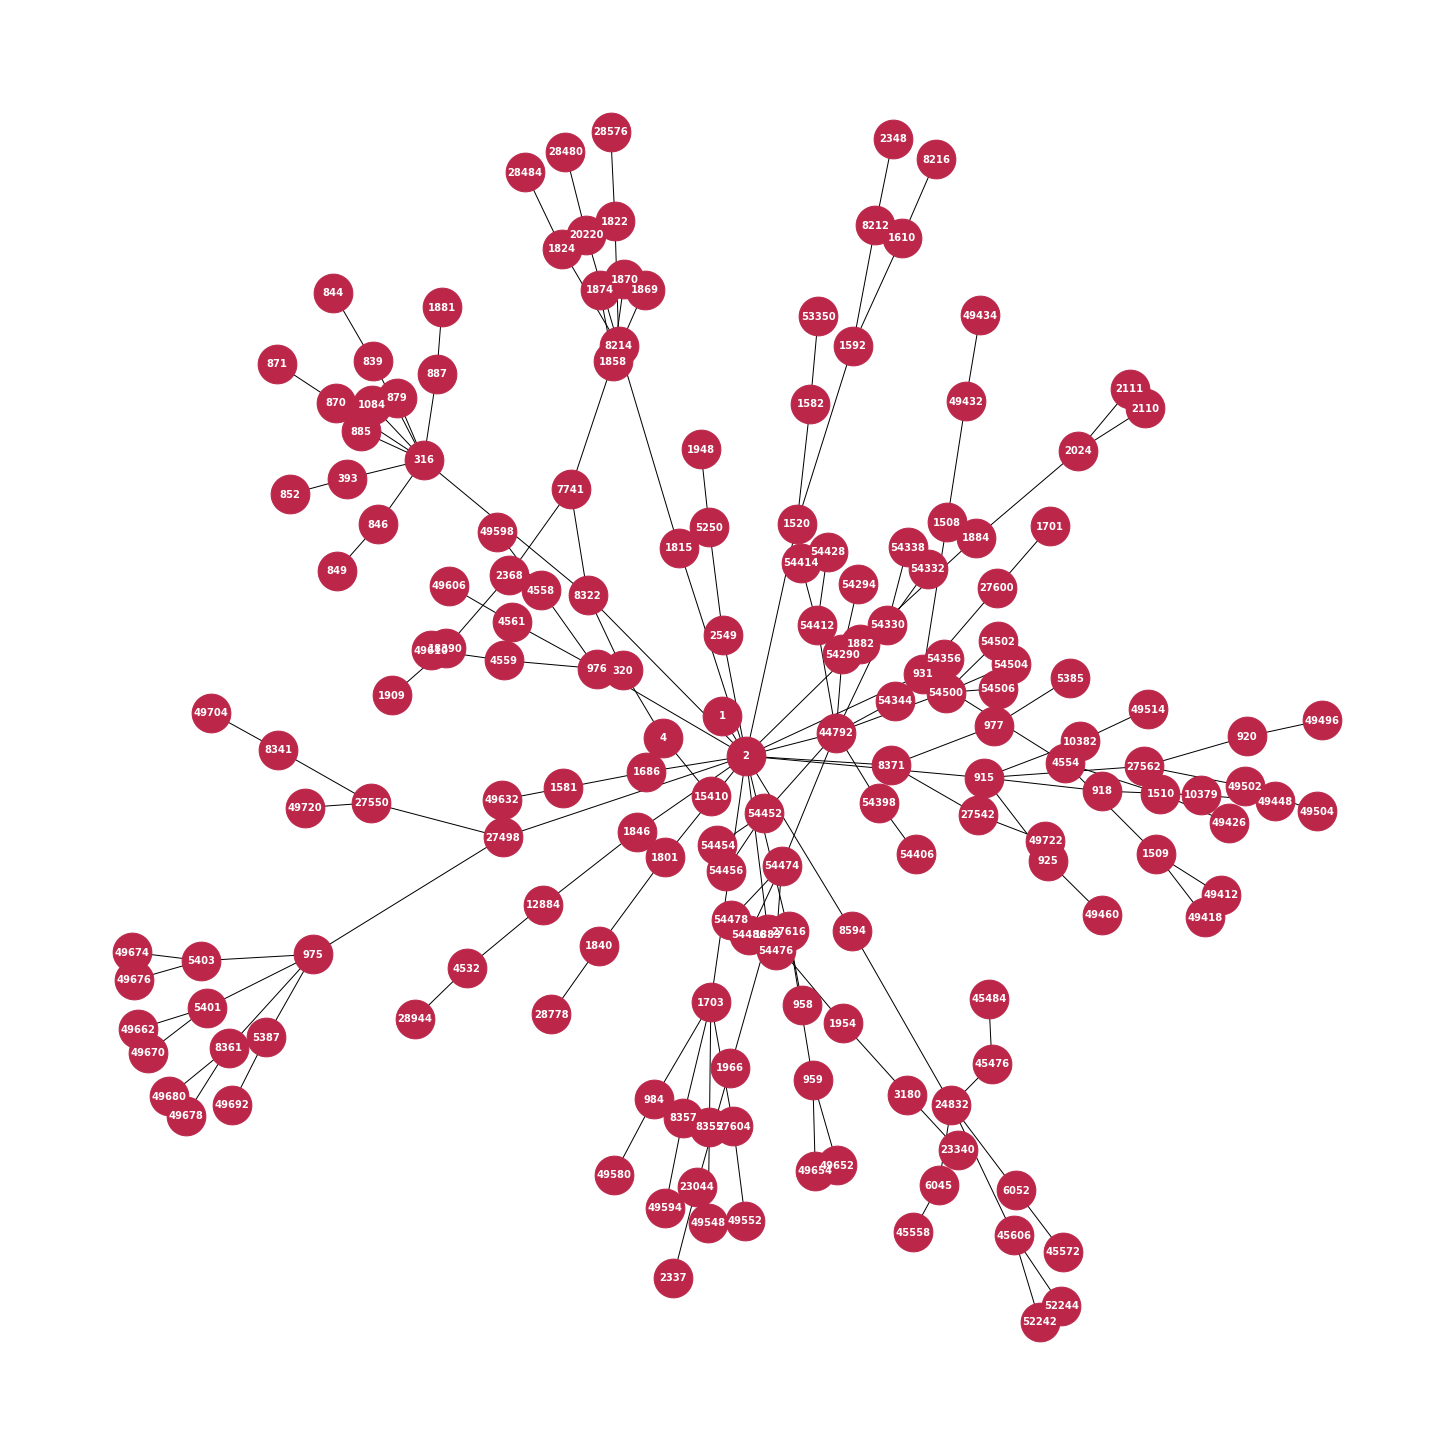

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with your connections
plt.figure(figsize=(20, 20))
dat = pd.DataFrame({ 'parent':parents, 'child':children})
 
# Build your graph
G=nx.from_pandas_edgelist(dat, 'parent', 'child')
 

# Custom the labels:
nx.draw(G, with_labels=True, node_size=1500, node_color='#BB2649', font_size=10, font_color="white", font_weight="bold")
# plt.show()

# # Spectral
# nx.draw(G, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold",pos=nx.spectral_layout(G))
# plt.show()


# Compare two Category Tree

In [ ]:
parents = []
children = []
rela = []

for c in categories[:200]:
    if (c['parent_id'], c['id']) not in rela:
        rela.append((c['parent_id'], c['id']))
        parents.append(c['parent_id'])
        children.append(c['id'])

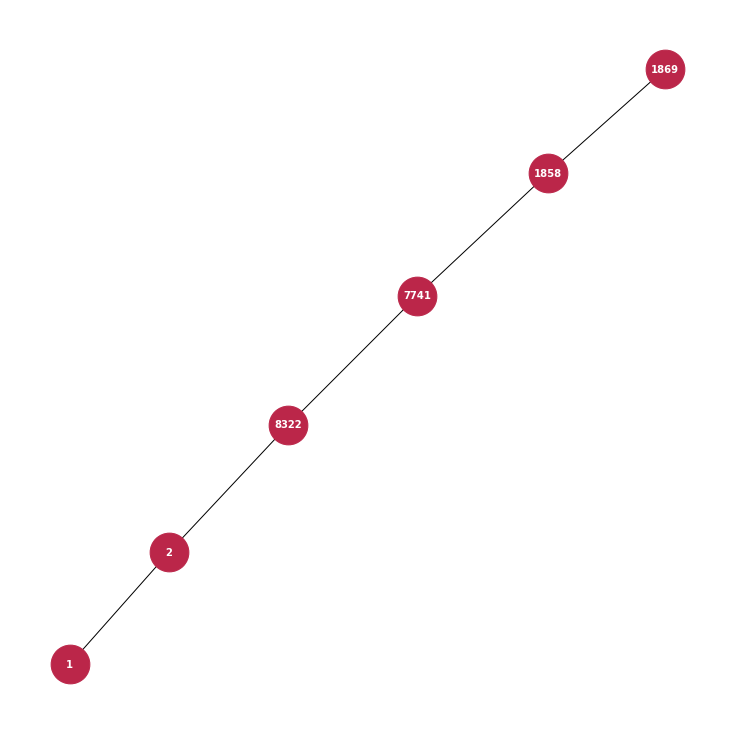

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with your connections
plt.figure(figsize=(10, 10))
dat = pd.DataFrame({ 'parent':parents, 'child':children})
 
# Build your graph
G=nx.from_pandas_edgelist(dat, 'parent', 'child')
 

# Custom the labels:
nx.draw(G, with_labels=True, node_size=1500, node_color='#BB2649', font_size=10, font_color="white", font_weight="bold")
# plt.show()

# Spectral
# nx.draw(G, with_labels=True, node_size=2000, node_color="#BB2649", font_size=10, font_color="white", font_weight="bold",pos=nx.spectral_layout(G))
# plt.show()


# Numerical Variables

In [ ]:
df = df.replace(-1, np.nan)

In [ ]:
df.head()

ID                                               Name     Price  \
0   45950473                               GIÀY TÂY NAM GT DB23  650000.0   
1  181998535                      Rượu Kuro Kirishima 25% 900ml  613000.0   
2  203917594  Dép quai ngang thêu chỉ đính khoá chanl ,praaa...   62000.0   
3  197146716                             Dầu Đậu Nành Meizan 2L  113200.0   
4    1754639  Bao Da Hộ Chiếu / PASSPORT Mika A-001-007-P (1...  198000.0   

   Discount  Rating  Inventory  Product  Sold  Shippable  Category_1  \
0       0.0     0.0  available     1461   NaN       True           1   
1       0.0     0.0  available     5211   NaN       True           1   
2      35.0     0.0  available     1451   NaN       True           1   
3       0.0     0.0  available     5205   NaN       True           1   
4       0.0     0.0  available     1445   NaN       True           1   

   Category_2  Category_3  Category_4  
0           2        1686        1581  
1           2       44792       54412  
2           2        1703         984  
3           2       44792       54362  
4           2       27616         959

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

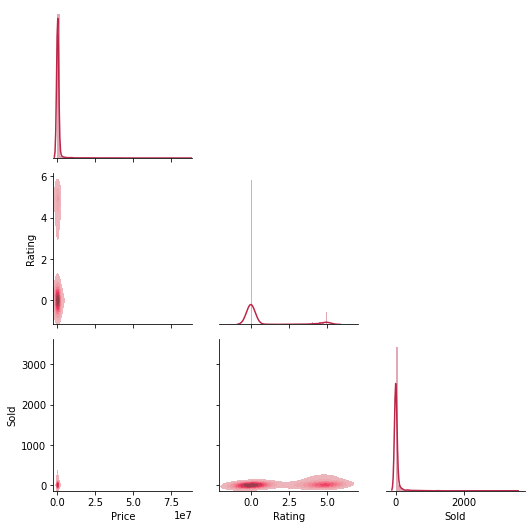

In [ ]:
g=sns.PairGrid(df, vars=['Price', 'Rating', 'Sold'], diag_sharey=False, corner=True)
def lower(*args, **kwargs):
    kwargs['color'] = "#BB2649"
    sns.kdeplot(*args, fill=True, **kwargs)
def diag(*args, **kwargs):
    kwargs['color'] = "#BB2649"
    sns.distplot(*args, hist=True, kde=True, rug=False, norm_hist=False, **kwargs)
g.map_lower(lower)
g.map_diag(diag)